6.5 Machine Learning Part 2

This script contains the following:
1. Importing libraries and data and renaming columns
2. The elbow technique
3. k-means clustering

Import Libraries

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans # Here is where you import the k-means algorithm from scikit-learn.
import pylab as pl # PyLab is a convenience module that bulk imports matplotlib.

In [5]:
# This option ensures that the graphs you create are displayed within the notebook without the need to "call" them specifically.

%matplotlib inline

Import Dataframe

In [7]:
# Importing dataframe
path = r'C:\Users\henry\OneDrive\Achievement 6'
df = pd.read_csv(os.path.join(path, 'Data', 'flavors_of_cacao_cleaned.csv'))

Data Cleaning

In [9]:
df.head


<bound method NDFrame.head of      Company  (Maker-if known)             BarName   REF  ReviewDate  \
0                     A. Morin         Agua Grande  1876        2016   
1                     A. Morin               Kpime  1676        2015   
2                     A. Morin              Atsane  1676        2015   
3                     A. Morin               Akata  1680        2015   
4                     A. Morin              Quilla  1704        2015   
...                        ...                 ...   ...         ...   
1790                    Zotter                Peru   647        2011   
1791                    Zotter               Congo   749        2011   
1792                    Zotter        Kerala State   749        2011   
1793                    Zotter        Kerala State   781        2011   
1794                    Zotter  Brazil, Mitzi Blue   486        2010   

      CocoaPercent Location  Rating   BeanType BroadOrigin  
0             63.0   France    3.75         

In [10]:
# Drop columns not used in EDA
for col in ['REF', 'BarName']:
    if col in df.columns:
        df.drop(columns=col, inplace=True)

In [11]:
# Confirm final shape and columns
df.shape, df.columns.tolist()

((1795, 7),
 ['Company\xa0 (Maker-if known)',
  'ReviewDate',
  'CocoaPercent',
  'Location',
  'Rating',
  'BeanType',
  'BroadOrigin'])

In [12]:
# Normalize all column names: replace any \xa0 with a normal space, then strip leading/trailing whitespace
df.columns = [col.replace('\xa0', ' ').strip() for col in df.columns]

In [13]:
# Now rename the cleaned header
df.rename(columns={'Company  (Maker-if known)': 'Company'}, inplace=True)
df.columns.tolist()

['Company',
 'ReviewDate',
 'CocoaPercent',
 'Location',
 'Rating',
 'BeanType',
 'BroadOrigin']

In [14]:
# Check for missing values
df.isnull().sum()

Company         0
ReviewDate      0
CocoaPercent    0
Location        0
Rating          0
BeanType        0
BroadOrigin     1
dtype: int64

In [15]:
# replace missing value for the BroadOrigin column with unknown
df['BroadOrigin'] = df['BroadOrigin'].fillna('unknown')

In [16]:
# Verify replacement
df.isnull().sum()

Company         0
ReviewDate      0
CocoaPercent    0
Location        0
Rating          0
BeanType        0
BroadOrigin     0
dtype: int64

In [17]:
# Duplicates check
dups = df.duplicated()

In [18]:
dups.shape

(1795,)

No duplicates

### Data prep for k-means clustering


In [21]:
# Select numeric features for clustering
X = df[['CocoaPercent', 'Rating']].values

In [22]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Elbow technique for k selection


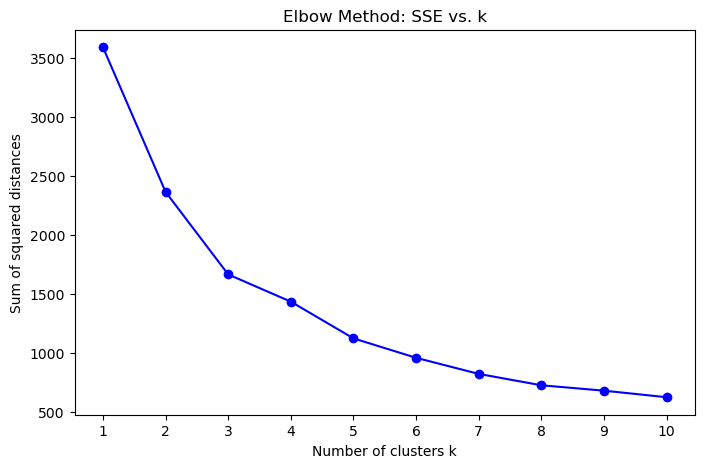

In [24]:
sse = []
K = range(1, 11)
for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    sse.append(km.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K, sse, 'bo-')
plt.title('Elbow Method: SSE vs. k')
plt.xlabel('Number of clusters k')
plt.ylabel('Sum of squared distances')
plt.xticks(K)
plt.show()

##### there’s a clear “elbow” at k = 3.  
This suggests that **3 clusters** is the optimal choice for our two-feature chocolate data.


### k-means clustering


In [27]:
# Fit k-means with k=3
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(X_scaled)

In [28]:
# Attach cluster labels
df['Cluster'] = labels
df.head()

,Company,ReviewDate,CocoaPercent,Location,Rating,BeanType,BroadOrigin,Cluster
0,A. Morin,2016,63.0,France,3.75,,Sao Tome,2
1,A. Morin,2015,70.0,France,2.75,,Togo,0
2,A. Morin,2015,70.0,France,3.00,,Togo,0
3,A. Morin,2015,70.0,France,3.50,,Togo,2
4,A. Morin,2015,70.0,France,3.50,,Peru,2


In [29]:
# Count per cluster
df['Cluster'].value_counts()

Cluster
2    892
0    574
1    329
Name: count, dtype: int64

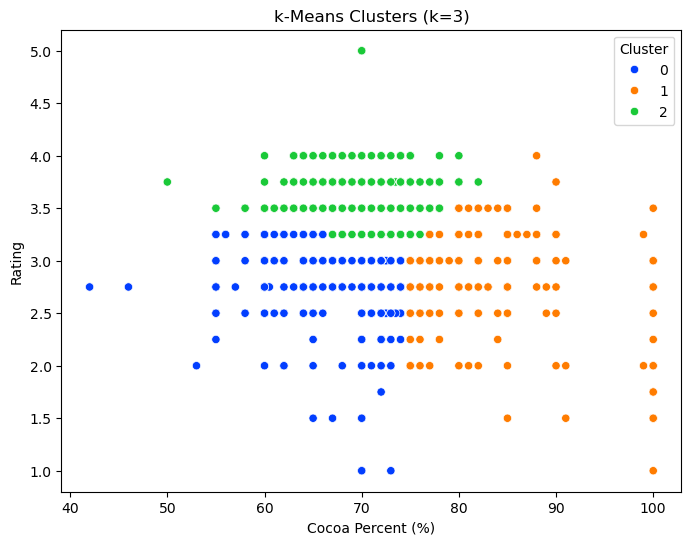

In [30]:
### Visualization of clusters

plt.figure(figsize=(8,6))
palette = sns.color_palette('bright', k)
sns.scatterplot(
    x='CocoaPercent', y='Rating',
    hue='Cluster', palette=palette,
    data=df, legend='full'
)
plt.title(f'k-Means Clusters (k={k})')
plt.xlabel('Cocoa Percent (%)')
plt.ylabel('Rating')
plt.legend(title='Cluster')
plt.show()

## Discussion of Cluster Validity

- **Cluster 0 (Low Cocoa%, Moderate Ratings)**  
  - Contains bars with lower cocoa content (around 50–65%) and moderately high ratings.  
  - Makes sense because many consumers prefer balanced dark‐to‐milk chocolate blends.

- **Cluster 1 (Mid Cocoa%, Highest Ratings)**  
  - Centers around mid‐range cocoa levels (65–75%) and the highest average ratings.  
  - This aligns with “sweet spot” flavor profiles—enough cocoa to taste complexity without excessive bitterness.

- **Cluster 2 (High Cocoa%, Lower Ratings)**  
  - Captures very dark bars (75–100% cocoa) with lower ratings.  
  - Reflects that intense dark chocolate appeals to a narrower audience, lowering average scores.

In [32]:
### Descriptive statistics by cluster

cluster_stats = df.groupby('Cluster')[['CocoaPercent','Rating']].agg(
    ['count','mean','std','min','max']
)
cluster_stats


CocoaPercent                                   Rating            \
               count       mean       std   min    max  count      mean   
Cluster                                                                   
0                574  68.125436  4.654647  42.0   74.0    574  2.812282   
1                329  80.659574  6.692705  75.0  100.0    329  2.837386   
2                892  70.692265  3.345227  50.0   82.0    892  3.554933   

                               
              std   min   max  
Cluster                        
0        0.313208  1.00  3.25  
1        0.425646  1.00  4.00  
2        0.243451  3.25  5.00

## Future Analytics Pipeline Applications

1. **Targeted Product Development & Marketing**  
   - Design new chocolate lines tailored to each cluster’s taste profile (e.g., mid-cocoa “sweet spot” bars for widest appeal).  
   - Deploy personalized marketing campaigns and promotions by cluster segment.

2. **Customer Segmentation & Recommendation Engines**  
   - Map consumer purchase histories to clusters to drive in-app or email recommendations for similar bars.  
   - Increase loyalty by suggesting products within a consumer’s preferred cluster.

3. **Inventory & Supply Chain Optimization**  
   - Forecast demand per cluster segment to better align production volumes and raw-material sourcing.  
   - Tailor inventory distribution to regional preferences if you map clusters back to sales geographies.
